In [1]:
import sys 
sys.path.append("..")

In [2]:
import umap
import operator
import shap
from xgboost import XGBClassifier
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from ksvd import ApproximateKSVD
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
#from comon import creatMas, plot_ssp, creat_data_month
from comon import *
from plots_report import plot_metrics

Using TensorFlow backend.


In [3]:
ocean = 'BarentsSea'

In [4]:
files = ['CZ1.txt', 'CZ2.txt', 'CZ3.txt', 'CZ4.txt','CZ5.txt', 'CZ6.txt',
         'CZ7.txt','CZ8.txt','CZ9.txt','CZ10.txt', 'CZ11.txt','CZ12.txt']

CZ = []
for file in files:
    with open('{0}/{1}'.format(ocean, file), 'r') as f:
        line = f.readlines()
        cz=creatMas(line)
    CZ.append(cz)
    
_, N_cord = cz.shape

with open('{}/zs.txt'.format(ocean), 'r') as f:
    line = f.readlines()
    line.remove(line[N_cord])
zs = [-int(a) for a in line]

In [5]:
X, Y = creat_data_month(CZ, N=200)
X = pd.DataFrame(X, columns=zs)
X_train, X_test, y_train, y_test = train_test_split(X, Y, shuffle=True, test_size=0.2, stratify=Y, random_state=0)

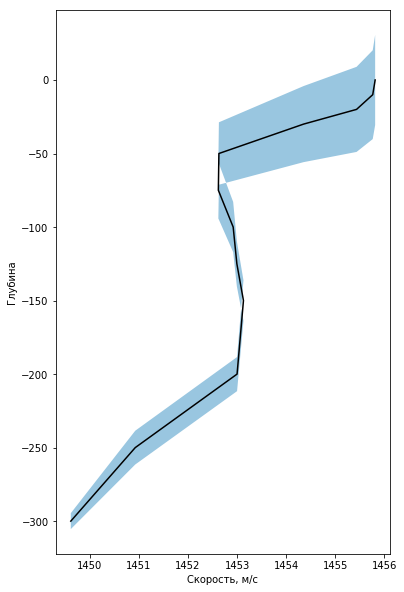

In [24]:
x  = np.array(X)
x_std = np.std(x, axis=0)
x_mean = np.mean(x, axis=0)
plt.figure(figsize=(6,10))
plt.plot(x_mean,zs, 'k')
plt.ylabel('Глубина')
plt.xlabel('Скорость, м/с')
plt.fill_between(x_mean, zs - 3*x_std, zs + 3*x_std, alpha=0.4)
plt.show()

## Кластеризация

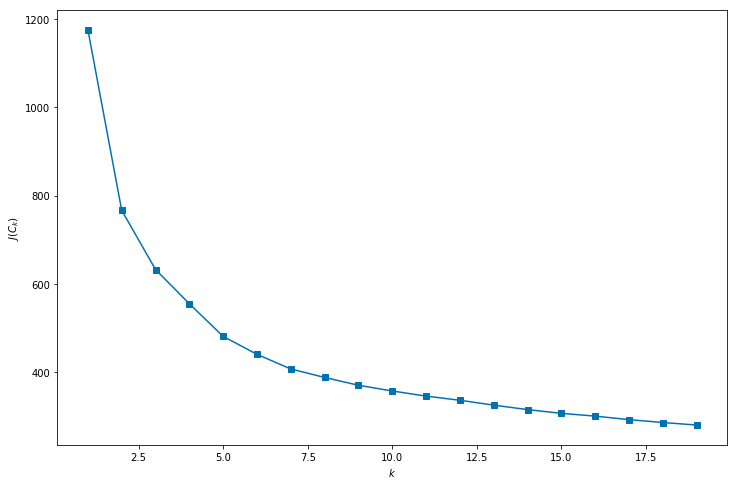

In [6]:
plt.figure(figsize=(12,8))
inertia = []
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(X)
    inertia.append(np.sqrt(kmeans.inertia_))

plt.plot(range(1, 20), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

## Классификация

In [7]:
clf = LogisticRegression()
clf.fit(X_train,y_train)
predict = clf.predict(X_test)
print('accuracy_score: ', accuracy_score(y_test,predict))
print(confusion_matrix(y_test,predict))
print(classification_report(y_test,predict))

accuracy_score:  0.8583333333333333
[[33  1  2  1  3  0  0  0  0  0  0  0]
 [ 0 35  1  0  4  0  0  0  0  0  0  0]
 [ 3  2 33  2  0  0  0  0  0  0  0  0]
 [12  0 10 13  4  0  0  0  0  0  0  1]
 [ 0  3  0  1 32  3  0  0  0  0  1  0]
 [ 0  0  0  1  0 39  0  0  0  0  0  0]
 [ 0  0  0  0  0  1 39  0  0  0  0  0]
 [ 0  0  0  0  0  0  1 35  4  0  0  0]
 [ 0  0  0  0  0  0  0  0 40  0  0  0]
 [ 0  0  0  0  0  0  0  0  2 38  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 40  0]
 [ 3  0  0  1  0  0  0  0  0  0  1 35]]
              precision    recall  f1-score   support

           0       0.65      0.82      0.73        40
           1       0.85      0.88      0.86        40
           2       0.72      0.82      0.77        40
           3       0.68      0.33      0.44        40
           4       0.74      0.80      0.77        40
           5       0.91      0.97      0.94        40
           6       0.97      0.97      0.97        40
           7       1.00      0.88      0.93        40
        

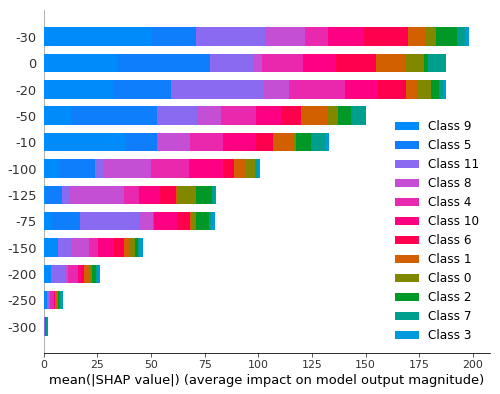

In [10]:
explainer = shap.LinearExplainer(clf, X_test)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type = "bar")

In [17]:
clf = XGBClassifier(n_estimators=500)
clf.fit(X_train,y_train)
predict = clf.predict(X_test)
print('accuracy_score: ', accuracy_score(y_test,predict))
print(confusion_matrix(y_test,predict))
print(classification_report(y_test,predict))

accuracy_score:  0.9666666666666667
[[134   2   2   0   0   0   0   0   0   0   0   2]
 [  4 136   0   0   0   0   0   0   0   0   0   0]
 [  2   3 129   5   1   0   0   0   0   0   0   0]
 [  0   1   4 130   4   1   0   0   0   0   0   0]
 [  0   0   1   5 133   1   0   0   0   0   0   0]
 [  0   0   0   0   0 140   0   0   0   0   0   0]
 [  0   0   0   0   0   2 138   0   0   0   0   0]
 [  0   0   0   0   0   0   0 140   0   0   0   0]
 [  0   0   0   0   0   0   0   0 140   0   0   0]
 [  1   0   1   1   3   0   0   0   0 134   0   0]
 [  0   1   0   0   1   0   0   0   0   1 137   0]
 [  3   1   0   1   0   0   0   0   0   0   2 133]]
              precision    recall  f1-score   support

           0       0.93      0.96      0.94       140
           1       0.94      0.97      0.96       140
           2       0.94      0.92      0.93       140
           3       0.92      0.93      0.92       140
           4       0.94      0.95      0.94       140
           5       0.97   

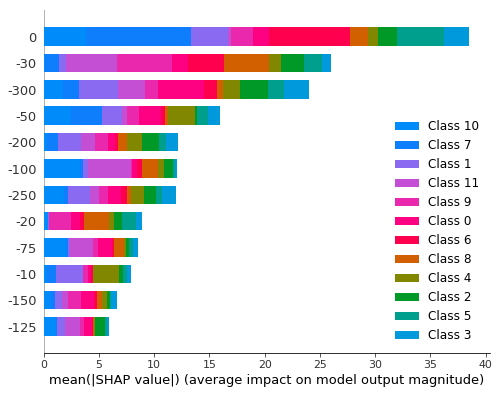

In [11]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type = "bar")

In [84]:
dec = PCA(n_components=len(zs))
clf = XGBClassifier(n_estimators=500)
pipe = Pipeline([('dec', dec), ('clf', clf)])
pipe.fit(X_train, y_train)
predict = pipe.predict(X_test)

print('accuracy_score: ', accuracy_score(y_test,predict))
print(confusion_matrix(y_test,predict))
print(classification_report(y_test,predict))

accuracy_score:  0.998214285714
[[140   0   0   0   0   0   0   0   0   0   0   0]
 [  1 139   0   0   0   0   0   0   0   0   0   0]
 [  0   0 140   0   0   0   0   0   0   0   0   0]
 [  1   0   0 139   0   0   0   0   0   0   0   0]
 [  0   0   0   0 140   0   0   0   0   0   0   0]
 [  0   0   0   0   0 140   0   0   0   0   0   0]
 [  0   0   0   0   0   0 140   0   0   0   0   0]
 [  0   0   0   0   0   0   0 140   0   0   0   0]
 [  0   0   0   0   0   0   0   0 140   0   0   0]
 [  0   0   0   0   0   0   0   0   0 140   0   0]
 [  0   0   0   0   0   0   0   0   0   0 139   1]
 [  0   0   0   0   0   0   0   0   0   0   0 140]]
             precision    recall  f1-score   support

          0       0.99      1.00      0.99       140
          1       1.00      0.99      1.00       140
          2       1.00      1.00      1.00       140
          3       1.00      0.99      1.00       140
          4       1.00      1.00      1.00       140
          5       1.00      1.00    

## Важность компонент

In [8]:
pca = PCA(n_components=len(zs))
pca.fit(X_train)
x_coef = pca.transform(X_train)
x_coef = pd.DataFrame(x_coef, columns = ['component {0}'.format(i) for i in range(1,len(zs)+1)])

In [9]:
clf = XGBClassifier(n_estimators=500)
clf.fit(x_coef,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

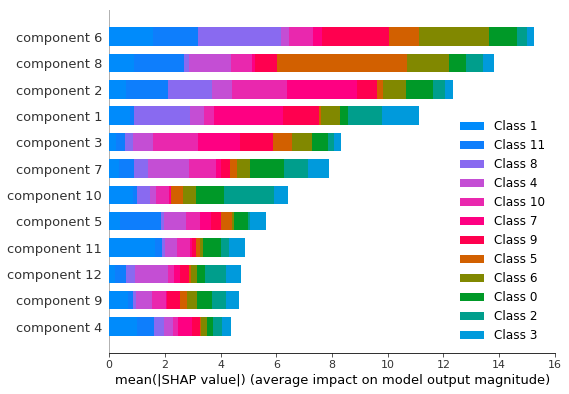

In [11]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(x_coef)
shap.summary_plot(shap_values, x_coef, plot_type = "bar")

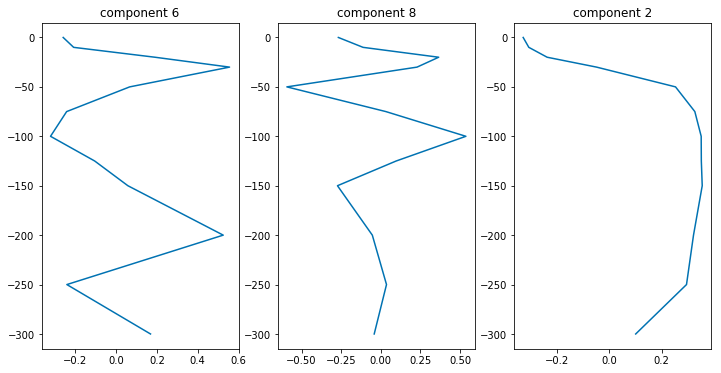

In [12]:
best_comp = [6,8,2]
n = len(best_comp)
comp = pca.components_
i=1
plt.figure(figsize=(12,6))
for bc in best_comp:
    plt.subplot(1,n, i)
    plt.plot(comp[bc-1,:],zs)
    plt.title('component {0}'.format(bc))
    i+=1
plt.show()

## Качество классификации при снижении размерности

In [17]:
score_pca = researcher_pca(XGBClassifier, X_train, y_train, X_test, y_test, n_estimators=500, n_comp=[2,3,5,7,10,12])
score_pca

[0.46041666666666664,
 0.7291666666666666,
 0.8604166666666667,
 0.9604166666666667,
 0.975,
 0.9729166666666667]

In [18]:
score_ksvd = researcher_ksvd(XGBClassifier, X_train.values, y_train, X_test.values, y_test, n_estimators=500, n_comp=[2,3,5,7,10,11])
score_ksvd

[0.2708333333333333,
 0.29791666666666666,
 0.7479166666666667,
 0.9125,
 0.9583333333333334,
 0.9729166666666667]

In [19]:
score_ae = researcher_ae(XGBClassifier, X_train.values, y_train, X_test.values, y_test, n_estimators=500, n_units=[2,3,5,7,10,12])
score_ae

[0.45416666666666666,
 0.6416666666666667,
 0.8083333333333333,
 0.9145833333333333,
 0.91875,
 0.9395833333333333]

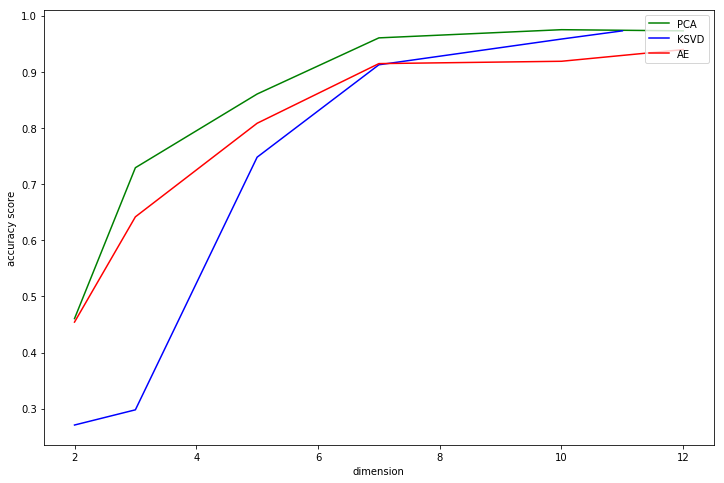

In [20]:
plt.figure(figsize=(12,8))
plt.plot([2,3,5,7,10,12], score_pca, 'g', [2,3,5,7,10,11], score_ksvd, 'b', [2,3,5,7,10,12], score_ae, 'r')
plt.legend(('PCA', 'KSVD', 'AE'),
           loc='upper right')
plt.xlabel('dimension')
plt.ylabel('accuracy score')
plt.show()

## Визуализация по месяцам

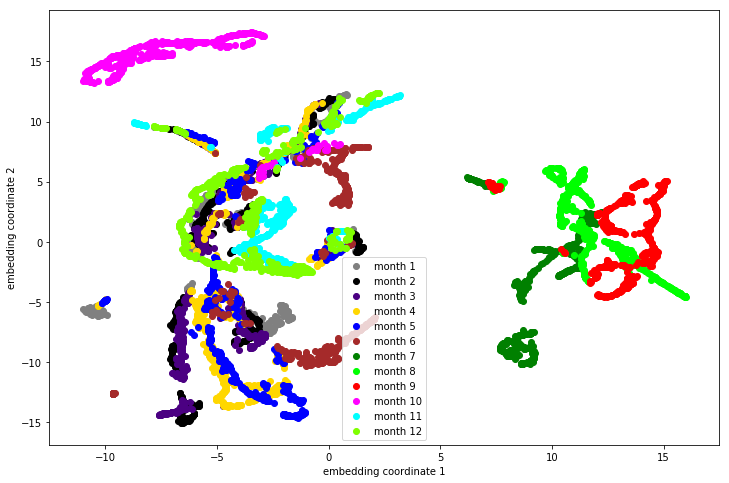

In [40]:
embedding = umap.UMAP()
AllX = []
for x in CZ:
    AllX += list(x)
embedding.fit(AllX)

plt.figure(figsize=(12,8))
color = ['grey', 'black', 'indigo', 'gold', 'blue', 'brown', 'green', 'lime', 'red', 'fuchsia', 'cyan', 'chartreuse']
for i in range(12):
    x_emb = embedding.transform(CZ[i])
    plt.scatter(x_emb[:,0], x_emb[:,1], label='month {}'.format(i+1), c=color[i])
plt.legend()
plt.xlabel('embedding coordinate 1')
plt.ylabel('embedding coordinate 2')
plt.show()

**визуальная разделимость от колличества  компонент PCA**

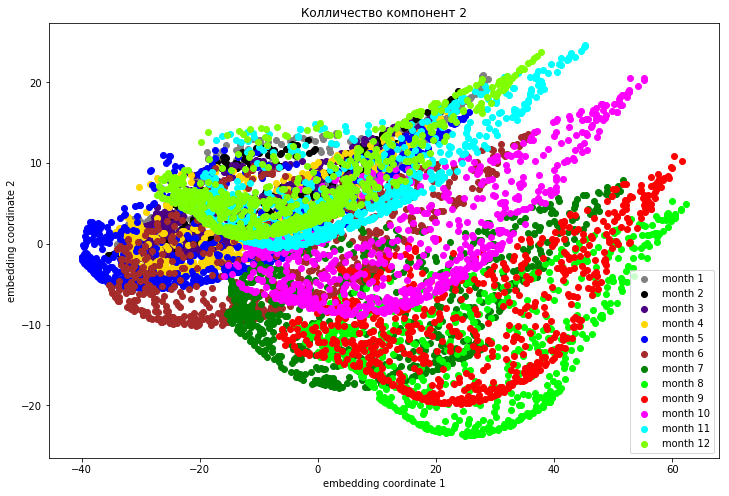

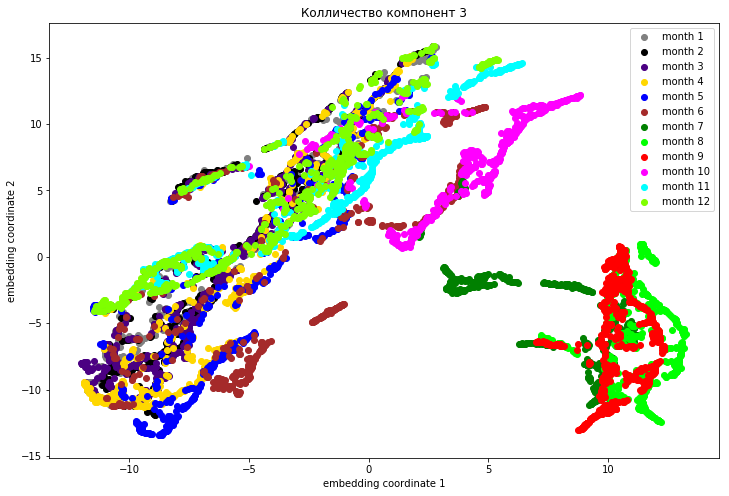

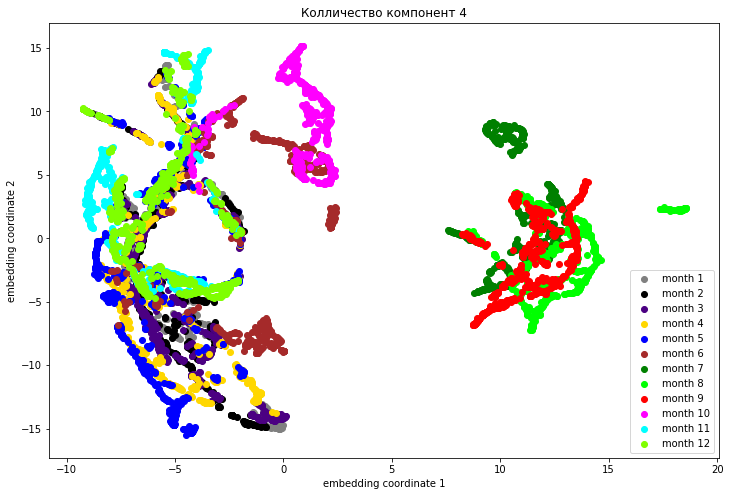

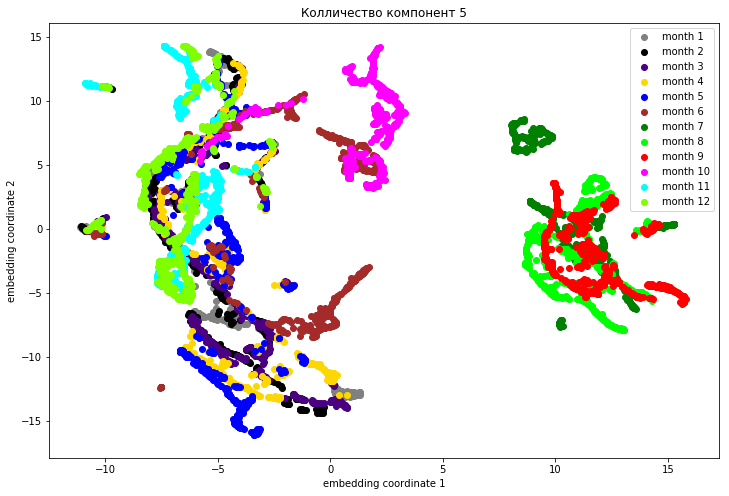

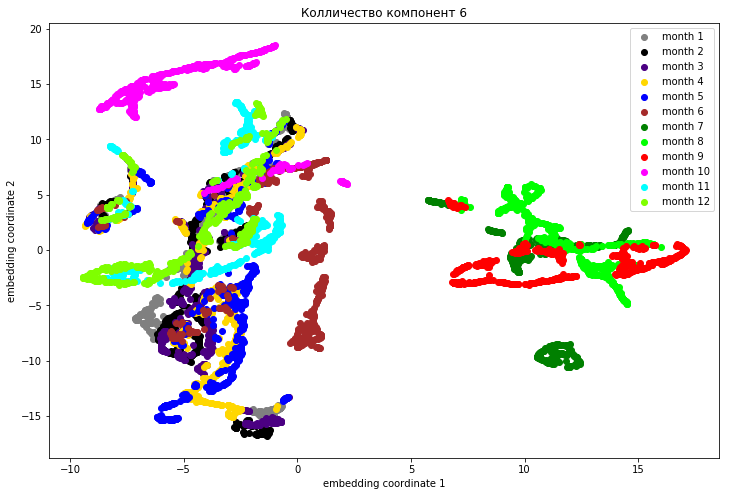

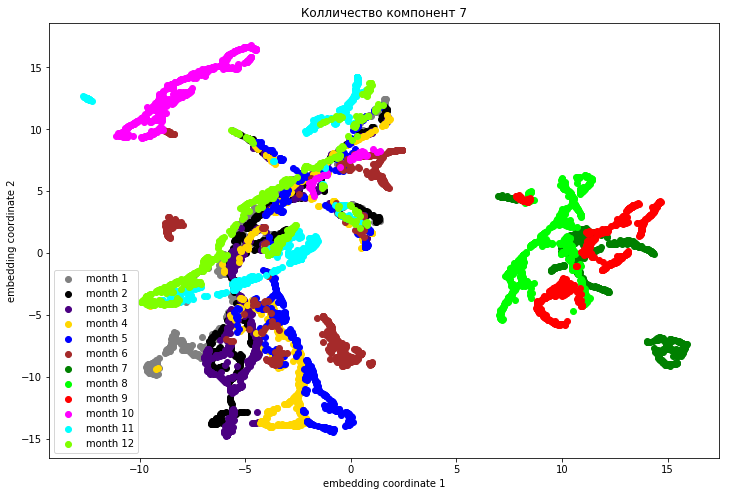

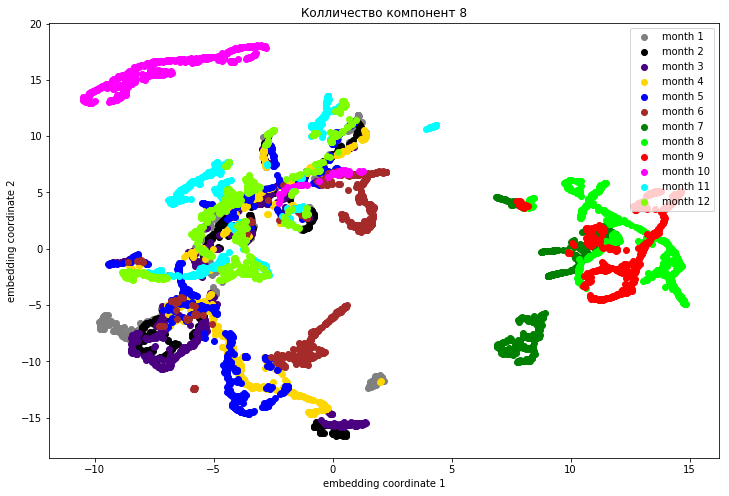

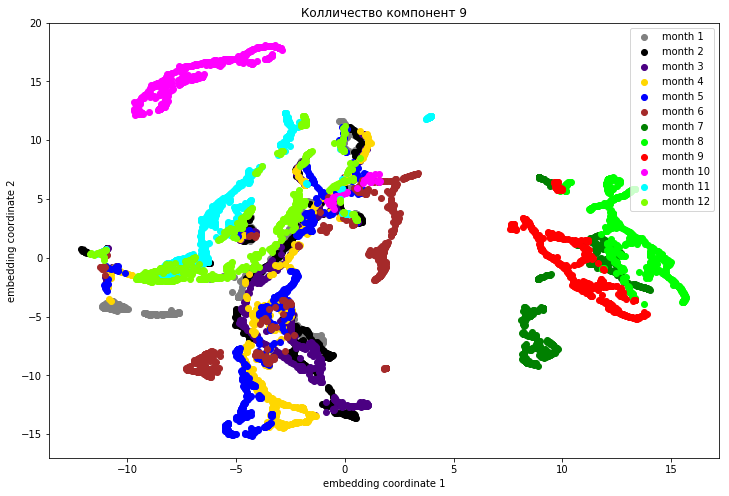

In [41]:
for n_comp in range(2,10):
    pca = PCA(n_components=n_comp)
    AllX_red = pca.fit_transform(AllX)
    embedding.fit(AllX_red)
    plt.figure(figsize=(12,8))
    for i in range(12):
        if n_comp == 2: x_emb = pca.transform(CZ[i])
        else: x_emb = embedding.transform(pca.transform(CZ[i]))
        plt.scatter(x_emb[:,0], x_emb[:,1], label='month {}'.format(i+1), c=color[i])
        plt.title("Колличество компонент {}".format(n_comp))
        plt.legend()
    plt.xlabel('embedding coordinate 1')
    plt.ylabel('embedding coordinate 2')
    plt.show()